In [3]:
import torch
from torch.utils.data import DataLoader
from torch import nn

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [5]:
paths = pd.Series({
    'gtgt': 'tests/00_test_img_gt/gt.csv',
    'gtshapes': 'tests/00_test_img_gt/img_shapes.csv',
    'inputtraingt': 'tests/00_test_img_input/train/gt.csv',
    'test_imgs': 'tests/00_test_img_input/test/images/',
    'train_imgs': 'tests/00_test_img_input/train/images/',
})

In [6]:
from run import read_csv

In [7]:
train_gt = read_csv(paths.inputtraingt)

In [8]:
# df_shapes = pd.read_csv(paths.gtshapes)
# whs = (df_shapes.n_rows / df_shapes.n_cols)
# df_shapes.loc[whs > 1.5]

In [9]:
# def index2img_path(index: int):
#     return f'{paths.train_imgs}{index:05}.jpg'

# def index2label(index: int):
#     return np.array(df_labels.iloc[index][[
#                 f'{a}{b}' 
#                 for b in range(1, 15) 
#                 for a in ['x', 'y']
#             ]])

In [10]:
def draw_point(img, crd, color=(0, 255, 0), r=5):
    assert len(img.shape) == 3
    assert len(crd) == 2
    assert len(color) == 3
    result = img.copy()
    x, y = int(crd[0]), int(crd[1])
    result[y-r:y+r+1, x-r:x+r+1] = color

    return result

point_colors = np.array([
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 1, 1],
    [0, 0, 1],
    [1, 0, 1],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 1, 1],
    [0, 0, 1],
    [1, 0, 1],
    [1, 1, 1],
    [1, 1, 1],
])

def draw_points(img, label, r=5):
    assert len(img.shape) == 3
    assert label.shape == (28,)
    
    result = img.copy()
    for i in range(0, 28, 2):
        x, y = label[i:i+2]
        result = draw_point(result, (x, y), 255 * point_colors[i // 2], r)
    
    return result

In [11]:
def resize(img, label, res_size):
    """
    :param: (original) img - (orig_h, orig_w, 3)-shaped rgb 0..255 image
    :param: (original) label - [x1, y1, ..., x7, y7] 0..orig_w(orig_h) array
    returns
    res_img - (h, w, 3)-shaped rgb 0..1 image
    res_label - [x1, y1, ..., x7, y7] 0..1 array
    """
    assert len(img.shape) == 3
    assert label.shape == (28,)
    assert len(res_size) == 2
    
    res_img = cv2.resize(img, res_size[::-1])
    assert res_size == res_img.shape[:2]
    
    res_img = res_img / 255
    
    res_label = label.copy()
    h, w, _ = img.shape
    for i in range(0, 28, 2):
        res_label[i] /= w
        res_label[i + 1] /= h
    
    return res_img, np.array(res_label, dtype=float)

def unresize(img, label, orig_size):
    """
    :param: img - (h, w, 3)-shaped rgb 0..1 image
    :param: label - [x1, y1, ..., x7, y7] 0..1 array
    returns
    res_img - (original) img - (orig_h, orig_w, 3)-shaped rgb 0..255 image
    res_label - (original) label - [x1, y1, ..., x7, y7] 0..orig_w(orig_h) array
    """
    assert len(img.shape) == 3
    assert label.shape == (28,)
    assert len(orig_size) == 2
    
    res_img = cv2.resize(img, orig_size[::-1])
    assert orig_size == res_img.shape[:2]
    
    res_img = res_img * 255
    
    res_label = label.copy()
    h, w = orig_size
    for i in range(0, 28, 2):
        res_label[i] *= w
        res_label[i + 1] *= h
    
    return np.array(res_img, dtype=int), res_label

In [12]:
BATCH_IMG_SIZE = 100

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, mode, train_gt, data_dir=paths.train_imgs, fraction=0.8):
        assert mode in ('train', 'val')
        # assert mode == 'train'
        
        items_count = len(train_gt.items())
        
        # list of tuples: img_filename, img_orig_shape(h, w), img(3x100x100)[0..1], label[0..1]
        
        if mode == 'train':
            r = range(int(fraction * items_count))
        elif mode == 'val':
            r = range(int(fraction * items_count), items_count)
        
        train_gt_items = list(train_gt.items())
        
        self.items = []
        for i in tqdm(r):
            img_filename, label = train_gt_items[i]
            
            img_path = data_dir + img_filename
            img = cv2.imread(img_path)[..., ::-1]
            assert img is not None
            assert len(img.shape) == 3
            
            img_orig_shape = img.shape[:2]
            
            assert label.shape == (28,)
            
            res_img, res_label = resize(img, label, (BATCH_IMG_SIZE, BATCH_IMG_SIZE))
            assert res_img.shape == (BATCH_IMG_SIZE, BATCH_IMG_SIZE, 3)
            assert res_label.shape == (28,)

            res_img = torch.from_numpy(res_img.transpose(2, 0, 1)).to(torch.float)
            res_label = torch.from_numpy(res_label).to(torch.float)
            assert res_img.shape == (3, BATCH_IMG_SIZE, BATCH_IMG_SIZE)
            assert res_label.shape == (28,)
            
            self.items.append((
                img_filename,
                img_orig_shape,
                res_img,
                res_label,
            ))
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, index):
        return self.items[index]

In [13]:
train_gt = {k: train_gt[k] for k in list(train_gt.keys())[:100]} # ...

train_dataset = MyDataset('train', train_gt, fraction=0.99)
val_dataset = MyDataset('val', train_gt, fraction=0.99)

len(train_dataset), len(val_dataset), train_dataset[0][2].shape, train_dataset[0][3].shape

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(99, 1, torch.Size([3, 100, 100]), torch.Size([28]))

In [14]:
BATCH_SIZE = 60

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [15]:
class MyModel(torch.nn.Module):
    def __init__(self, dropout=0.0):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout2d(dropout)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout2d(dropout)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout2d(dropout)
        self.maxpool3 = nn.MaxPool2d(2)
        self.lin4 = nn.Linear(36864, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(dropout)
        self.lin5 = nn.Linear(64, 28)
    
    def forward(self, batch):
        batch = self.maxpool1(self.drop1(self.relu1(self.bn1(self.conv1(batch)))))
        batch = self.maxpool2(self.drop2(self.relu2(self.bn2(self.conv2(batch)))))
        batch = self.maxpool3(self.drop3(self.relu3(self.bn3(self.conv3(batch)))))
        batch = torch.flatten(batch, 1)
        batch = self.drop4(self.relu4(self.bn4(self.lin4(batch))))
        batch = self.lin5(batch)
        return batch

In [16]:
def train(model, optimizer, dataloader, criterion):
    model.train()
    losses_tr = []
    
    for _, _, images, labels in tqdm(dataloader, leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(BATCH_IMG_SIZE * out, BATCH_IMG_SIZE * labels)

        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)

def val(model, dataloader, criterion):
    model.eval()
    losses_val = []
    
    with torch.no_grad():
        for _, _, images, labels in tqdm(dataloader, leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            out = model(images)
            loss = criterion(BATCH_IMG_SIZE * out, BATCH_IMG_SIZE * labels)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

In [17]:
model = MyModel(dropout=0.05).to(device)
losses_tr, losses_val = [], []

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [19]:
EPOCHS = 90
for epoch in tqdm(range(EPOCHS)):
    model, optimizer, loss_tr = train(model, optimizer, train_dataloader, criterion)
    loss_val = val(model, val_dataloader, criterion)
    
    losses_tr.append(loss_tr)
    losses_val.append(loss_val)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

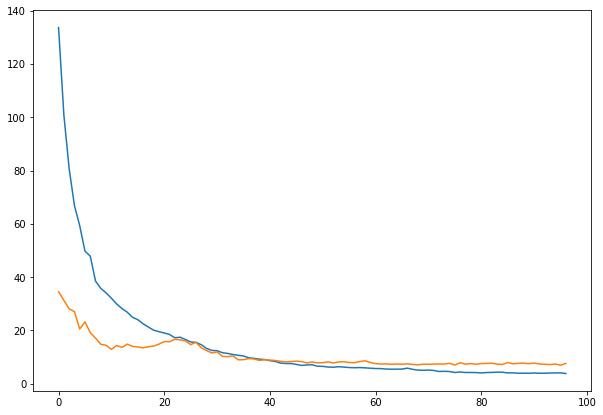

In [53]:
plt.figure(figsize=(10,7))
plt.plot(losses_tr[1:])
plt.plot(losses_val[1:])
plt.show()

In [54]:
len(losses_tr)

98

In [51]:
losses_tr[-1]

3.8131254393645007

In [52]:
# torch.save(model.to(torch.device('cpu')).state_dict(), 'facepoints_model.ckpt')

In [303]:
filenames, orig_shapes, images, labels = next(iter(val_dataloader))

In [304]:
index = 1
filename = filenames[index]
orig_size = (int(orig_shapes[0][index]), int(orig_shapes[1][index]))
img = images[index].cpu().detach().numpy().transpose(1, 2, 0)
label = labels[index]

with torch.no_grad():
    pred = model(images.to(device))
    pred_label = pred[index].cpu().detach().numpy()
    
orig_img, orig_label = unresize(img, pred_label, orig_size)

In [38]:
# plt.figure(figsize=(5, 5))
# plt.imshow(draw_points(img, BATCH_IMG_SIZE * label, r=1))
# plt.show()

In [39]:
# plt.figure(figsize=(5, 5))
# plt.imshow(draw_points(img, BATCH_IMG_SIZE * pred_label, r=1))
# plt.show()

In [40]:
# plt.figure(figsize=(5, 5))
# plt.imshow(draw_points(orig_img, orig_label, r=1))
# plt.show()

In [113]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        # list of tuples: img_filename, img_orig_shape(h, w), img(3x100x100)[0..1]
        
        filenames = os.listdir(data_dir)
        
        self.items = []
        for img_filename in tqdm(filenames):
            
            img_path = data_dir + img_filename
            img = cv2.imread(img_path)[..., ::-1]
            assert img is not None
            assert len(img.shape) == 3
            
            img_orig_shape = img.shape[:2]
            
            label = np.zeros(28)
            assert label.shape == (28,)
            
            res_img, res_label = resize(img, label, (BATCH_IMG_SIZE, BATCH_IMG_SIZE))
            assert res_img.shape == (BATCH_IMG_SIZE, BATCH_IMG_SIZE, 3)

            res_img = torch.from_numpy(res_img.transpose(2, 0, 1)).to(torch.float)
            assert res_img.shape == (3, BATCH_IMG_SIZE, BATCH_IMG_SIZE)
            
            self.items.append((
                img_filename,
                img_orig_shape,
                res_img,
            ))
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, index):
        return self.items[index]

In [114]:
test_dataset = TestDataset(paths.test_imgs)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [115]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [133]:
def test(model, dataloader):
    model.eval()
    
    result_labels = {}
    
    with torch.no_grad():
        for img_filenames, img_orig_shapes, images in tqdm(dataloader, leave=False):            
            images = images.to(device)
            
            out = model(images)
            
            labels = out.cpu().detach().numpy()
            for label in range(len(labels)):
                for i in range(0, 28, 2):
                    h, w = img_orig_shapes[0][label], img_orig_shapes[1][label], 
                    labels[label][i] *= w
                    labels[label][i + 1] *= h
                
                result_labels[img_filenames[label]] = labels[label]
            # print(labels)
            # print(img_orig_shapes)
            # break
            
            # result_labels.extend(labels)

    return result_labels

In [134]:
res_labels = test(model, test_dataloader)

  0%|          | 0/60 [00:00<?, ?it/s]

In [118]:
len(res_labels)

6000

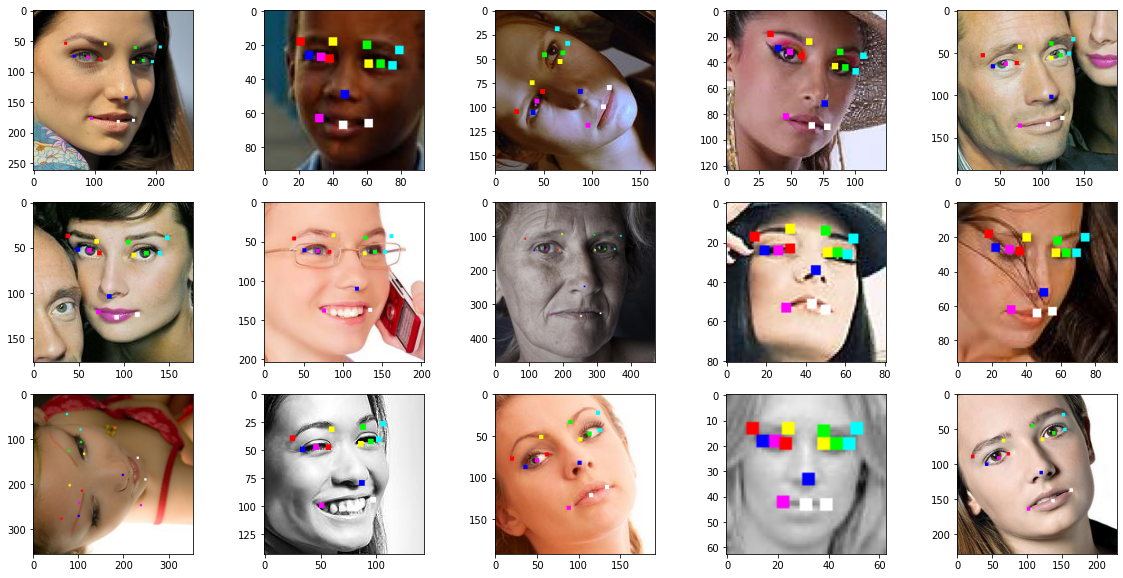

In [132]:

rows, cols = 3, 5

f = plt.figure(figsize=(30, 15))


filenames = [f'{elem:05}.jpg' for elem in range(15)]
it = iter(filenames)

for i in range(rows):
    for j in range(cols):
        filename = next(it)
        img = cv2.imread(paths.test_imgs + filename)[..., ::-1]
        label = res_labels[filename]

        f.add_subplot(rows, cols, cols * i + j + 1)
        plt.imshow(draw_points(img, label, r=2))
plt.show()